# **Overview**
The objective of this project is to create a deep learning based land clutter identification model using EuroSAT Satellite Imagery.

**About Dataset**
Using RGB satellite images from [EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Classification](https://zenodo.org/record/7711810#.ZCtEhOzMJQK).
This dataset contains 27,000 RGB Satellite Images across 10 classes:
- Annual Crop
- Forest
- Herbaceous Vegetation
- Highway
- Industrial
- Pasture
- Permanent Crop
- Residential
- River
- Sea or Lake

There are about 2,500 images per class.

# Importing Libraries/Modules

In [1]:
import numpy as np
import pandas as pd

import os
import shutil

from PIL import Image, ImageOps

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

## Data Processing

In [ ]:
# Path for all clutter types
clutter_paths = {
    'AnnualCrop': 'C:/Users/Kavya/Project/EuroSAT_RGB/AnnualCrop',
    'Forest': 'C:/Users/Kavya/Project/EuroSAT_RGB/Forest',
    'HerbaceousVegetation': 'C:/Users/Kavya/Project/EuroSAT_RGB/HerbaceousVegetation',
    'Highway': 'C:/Users/Kavya/Project/EuroSAT_RGB/Highway',
    'Industrial': 'C:/Users/Kavya/Project/EuroSAT_RGB/Industrial',
    'Pasture': 'C:/Users/Kavya/Project/EuroSAT_RGB/Pasture',
    'PermanentCrop': 'C:/Users/Kavya/Project/EuroSAT_RGB/PermanentCrop',
    'Residential': 'C:/Users/Kavya/Project/EuroSAT_RGB/Residential',
    'River': 'C:/Users/Kavya/Project/EuroSAT_RGB/River',
    'SeaLake': 'C:/Users/Kavya/Project/EuroSAT_RGB/SeaLake'
}

In [ ]:
# Objects that will store all the relevant images
objects = {}
for category, path in clutter_paths.items():
    objects[category] = [file for file in os.listdir(path) if file.endswith('.jpg')]

# Unpack the dictionary into individual variables for object names
for category, object_list in objects.items():
    globals()[f"obj_{category}"] = object_list

print("\nObject Lists:")
for category, obj_list in objects.items():
    print(f"{category}: {len(obj_list)} objects found")



Object Lists:
AnnualCrop: 3000 objects found
Forest: 3000 objects found
HerbaceousVegetation: 3000 objects found
Highway: 2500 objects found
Industrial: 2500 objects found
Pasture: 2000 objects found
PermanentCrop: 2500 objects found
Residential: 3000 objects found
River: 2500 objects found
SeaLake: 3000 objects found


# Train and Test Split

In [ ]:
# Set up the Train folder and subfolders
proj_dir = 'C:/Users/Kavya/Project/eurosat_data/split/'

train_folder = os.path.join(proj_dir, 'train')

# Create train subfolders with names like test_AnnualCrop, test_Forest, etc.
train_folders = {f"{category}": os.path.join(train_folder, f"{category}") for category in clutter_paths}

# Ensure that train_folder exists before creating subfolders
if not os.path.exists(train_folder):
    os.mkdir(train_folder)
    print(f"Train folder '{train_folder}' created successfully!")
else:
    print(f"Train folder '{train_folder}' already exists.")

# Create subfolders
for category, folder_path in train_folders.items():
    try:
        os.mkdir(folder_path)
        print(f"folder '{folder_path}' created successfully!")
    except FileExistsError:
        print(f"folder '{folder_path}' already exists.")

Train folder 'C:/Users/Kavya/Project/eurosat_data/split/train' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\AnnualCrop' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\Forest' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\HerbaceousVegetation' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\Highway' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\Industrial' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\Pasture' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\PermanentCrop' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\Residential' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\River' created successfully!
folder 'C:/Users/Kavya/Project/eurosat_data/split/train\SeaLake' created successfully!


In [ ]:
test_folder = os.path.join(proj_dir, 'test')

# Create train subfolders with names like test_AnnualCrop, test_Forest, etc.
test_folders = {f"{category}": os.path.join(test_folder, f"{category}") for category in clutter_paths}

# Ensure that train_folder exists before creating subfolders
if not os.path.exists(test_folder):
    os.mkdir(test_folder)
    print(f"Test folder '{test_folder}' created successfully!")
else:
    print(f"Test folder '{test_folder}' already exists.")

# Create subfolders
for category, folder_path in test_folders.items():
    try:
        os.mkdir(folder_path)
        print(f" folder '{folder_path}' created successfully!")
    except FileExistsError:
        print(f" folder '{folder_path}' already exists.")

Test folder 'C:/Users/Kavya/Project/eurosat_data/split/test' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\AnnualCrop' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\Forest' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\HerbaceousVegetation' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\Highway' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\Industrial' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\Pasture' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\PermanentCrop' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\Residential' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\River' created successfully!
 folder 'C:/Users/Kavya/Project/eurosat_data/split/test\SeaLake' created successfully!


In [ ]:
# Defining a function to copy images from source to destination folder
def copy_images(source_folder, destination_folder, image_list):
    for img in image_list:
        origin = os.path.join(source_folder, img)
        destination = os.path.join(destination_folder, img)
        shutil.copyfile(origin, destination)

# Defining image counts for train and test sets
train_counts = {
    'AnnualCrop': 2400,
    'Forest': 2400,
    'HerbaceousVegetation': 2400,
    'Highway': 2000,
    'Industrial': 2000,
    'Pasture': 1600,
    'PermanentCrop': 2000,
    'Residential': 2400,
    'River': 2000,
    'SeaLake': 2400
}

test_counts = {
    'AnnualCrop': 600,
    'Forest': 600,
    'HerbaceousVegetation': 600,
    'Highway': 500,
    'Industrial': 500,
    'Pasture': 400,
    'PermanentCrop': 500,
    'Residential': 600,
    'River': 500,
    'SeaLake': 600
}
data_folder = 'C:/Users/Kavya/Project/EuroSAT_RGB/'

# Copying images for train set
for category, count in train_counts.items():
    imgs = os.listdir(os.path.join(data_folder, category))[:count]
    copy_images(os.path.join(data_folder, category), os.path.join(train_folder, category), imgs)

# Copying images for test set
for category, count in test_counts.items():
    imgs = os.listdir(os.path.join(data_folder, category))[train_counts[category]:train_counts[category]+count]
    copy_images(os.path.join(data_folder, category), os.path.join(test_folder, category), imgs)


In [ ]:
train_folder = 'C:/Users/Kavya/Project/eurosat_data/split/train'

test_folder = 'C:/Users/Kavya/Project/eurosat_data/split/test'

# Normalize images
train_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.15)
test_gen = ImageDataGenerator(rescale=1./255)

#Importing data - 65% Train, 15% Validation and 20% Test
train_generator = train_gen.flow_from_directory(train_folder,class_mode = 'categorical', subset ='training', batch_size=128,shuffle=True,seed=42)

val_generator= train_gen.flow_from_directory(train_folder,class_mode= 'categorical',subset = "validation",batch_size=128,shuffle=True,seed=42)

test_generator= test_gen.flow_from_directory(test_folder,class_mode= 'categorical',batch_size=128,shuffle=False, seed=42)

# Creating final datasets

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 18360 images belonging to 10 classes.
Found 3240 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


# Data Exploration

In [ ]:
# Confirm class balance for train and test
train_classes = train_generator.classes
val_classes = val_generator.classes
test_classes = test_generator.classes

# Look at image distribution by class across train, test, and validation sets
train_class_counts = dict(zip(*np.unique(train_classes, return_counts=True)))
val_class_counts = dict(zip(*np.unique(val_classes, return_counts=True)))
test_class_counts = dict(zip(*np.unique(test_classes, return_counts=True)))

# Data
class_names = list(train_generator.class_indices.keys())
classes = list(train_class_counts.keys())
train_counts = list(train_class_counts.values())
val_counts = list(val_class_counts.values())
test_counts = list(test_class_counts.values())


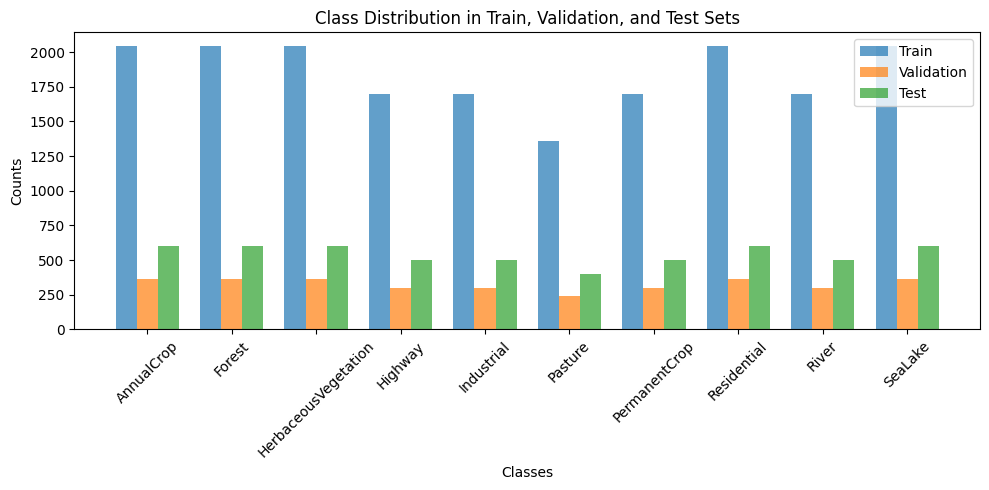

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
bar_width = 0.25
index = range(len(classes))

plt.bar(index, train_counts, bar_width, label='Train', alpha=0.7)
plt.bar([i + bar_width for i in index], val_counts, bar_width, label='Validation', alpha=0.7)
plt.bar([i + 2 * bar_width for i in index], test_counts, bar_width, label='Test', alpha=0.7)

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution in Train, Validation, and Test Sets')
plt.xticks([i + bar_width for i in index], class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

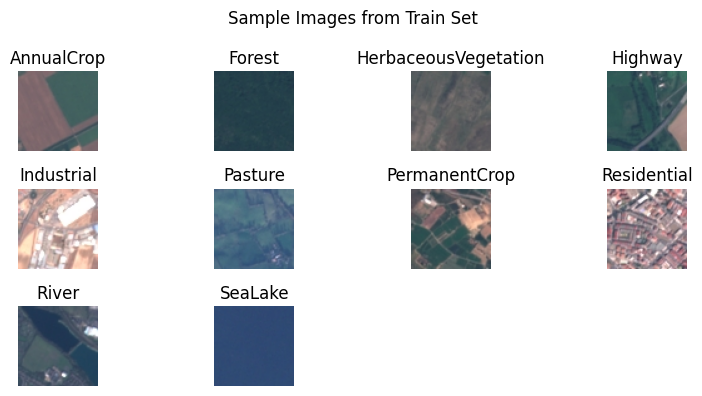

In [ ]:
def display_sample_images(images, labels, classes, title):
    plt.figure(figsize=(8, 4))
    num_classes = len(classes)

    for i in range(num_classes):
        image_index = np.where(labels[:, i] == 1)[0][0]
        plt.subplot(3, num_classes // 3 + 1, i + 1)
        plt.imshow(images[image_index])
        plt.title(class_names[i])
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

display_sample_images(train_images, train_labels, class_names, 'Sample Images from Train Set')

In [ ]:
#Shapes of train, validation, and test datasets
print("Train Dataset:")
print("Images Shape:", train_images.shape)
print("Labels Shape:", train_labels.shape)
print("\nValidation Dataset:")
print("Images Shape:", val_images.shape)
print("Labels Shape:", val_labels.shape)
print("\nTest Dataset:")
print("Images Shape:", test_images.shape)
print("Labels Shape:", test_labels.shape)

Train Dataset:
Images Shape: (128, 256, 256, 3)
Labels Shape: (128, 10)

Validation Dataset:
Images Shape: (128, 256, 256, 3)
Labels Shape: (128, 10)

Test Dataset:
Images Shape: (128, 256, 256, 3)
Labels Shape: (128, 10)


# **Model Creation and Evaluation**

## Baseline Model
The baseline Model will be a simple Sequential Neural Network with one Convolutional Layer, one Max Pooling Layer, and one Dense Layer

In [ ]:
# Instantiating a Sequential model
baseline_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),  # Input Layer - Convolution
    MaxPooling2D(pool_size=(2, 2)),                                                        # Layer 1 - Max pooling in 2x2 window
    Flatten(),                                                                             # Layer 2 - Flatten layer
    Dense(64, activation='relu'),                                                          # Layer 3 - Dense layer with 32 nodes
    Dense(10, activation='softmax')                                                        # Output Layer - Softmax activation for multi-categorical with 10 classes
])

# Compiling the sequential CNN model
baseline_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Printing model summary
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 516128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │      33,032,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,033,802 (126.01 MB)

 Trainable params: 33,033,802 (126.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
baseline_history = baseline_model.fit(train_generator,
                                      epochs = 20,
                                      batch_size= 128,
                                      verbose = 1,
                                      validation_data = val_generator)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.2887 - loss: 4.4364 - val_accuracy: 0.6059 - val_loss: 1.1012
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.6241 - loss: 1.0512 - val_accuracy: 0.6630 - val_loss: 0.9673
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.7075 - loss: 0.8596 - val_accuracy: 0.6948 - val_loss: 0.8964
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.7409 - loss: 0.7617 - val_accuracy: 0.7000 - val_loss: 0.8279
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.7862 - loss: 0.6549 - val_accuracy: 0.7074 - val_loss: 0.8229
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.8042 - loss: 0.5779 - val_accuracy: 0.7259 - val_loss: 0.8443
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8302 - loss: 0.5169 - val_accuracy: 0.7293 - val_loss: 0.7885
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.8439 - loss: 0.4815 - val_accu

In [ ]:
#Model evaluation- Checking loss and accuracy on test data
test_loss, test_acc = baseline_model.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 657ms/step - accuracy: 0.7433 - loss: 0.9924
Test loss:  1.0100334882736206
Test accuracy:  0.7342592477798462


##### After 20 Epochs the baseline model is overfitting with 98.4% train accuracy, 73.7% validation accurcay  and a 73.4% test accuracy

In [ ]:
#Saving the model
from tensorflow.keras.models import save_model
model_path = 'C:/Users/Administrator/Desktop/tensor/baseline_model.keras'

# Save the model architecture and weights
baseline_model.save(model_path)

## First Model

### Adding Dense Layer and L1 Regularization

In [ ]:
# Instantiating the model
model1 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3),kernel_regularizer=regularizers.l1(0.005)),  # Added l1 regularization
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l1(0.005)), # added another 2D layer with l1 legularization
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.005)),  #added l1 regularization
    Dense(10, activation='softmax')
])
# Compiling the model
model1.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Printing model summary
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,883,370 (30.07 MB)

 Trainable params: 7,883,370 (30.07 MB)

 Non-trainable params: 0 (0.00 B)

#### Defining Early Stopping

In [ ]:
# Defining Stopping Criteria
callback1 = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model1_history = model1.fit(train_generator,
                                  epochs= 20,
                                  validation_data = val_generator,
                                  callbacks= callback1,
                                  batch_size=128,
                                  verbose = 1)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.1355 - loss: 28.7946 - val_accuracy: 0.2028 - val_loss: 7.8853
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.2285 - loss: 7.6117 - val_accuracy: 0.2481 - val_loss: 7.2210
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.2438 - loss: 7.1793 - val_accuracy: 0.2713 - val_loss: 7.0557
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.2548 - loss: 6.9454 - val_accuracy: 0.2941 - val_loss: 6.8757
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.2621 - loss: 6.8121 - val_accuracy: 0.2787 - val_loss: 6.8093
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.2639 - loss: 6.7273 - val_accuracy: 0.2910 - val_loss: 6.6722
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.2720 - loss: 6.6817 - val_accuracy: 0.2556 - val_loss: 6.7635
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.2822 - loss: 6.6576 - val_acc

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model1.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 896ms/step - accuracy: 0.2838 - loss: 6.6937
Test loss:  6.718238353729248
Test accuracy:  0.26592591404914856


##### The model did not perform well. After 10 epochs(early stopping) it gave 29% train accuracy, 27% validation accuracy and 26.5% test accuracy.

## Second Model

### Adding Dropout and L2 Regularization

In [ ]:
# Instantiating the model
model2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3),kernel_regularizer=regularizers.l2(0.005)),  # Added l2 regularization
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Added  Dropout
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.005)), #Added l2 regularization
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2), # Added  Dropout
    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.005)),  #Added l2 regularization
    Dense(10, activation='softmax')
])
# Compiling the model
model2.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Printing model summary
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │       3,936,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,949,194 (15.06 MB)

 Trainable params: 3,949,194 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
model2_history = model2.fit(train_generator,
                                  epochs= 20,
                                  validation_data = val_generator,
                                  callbacks= callback1,
                                  batch_size=128,
                                  verbose = 1)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.1483 - loss: 2.9241 - val_accuracy: 0.3145 - val_loss: 1.9566
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.3803 - loss: 1.8602 - val_accuracy: 0.4580 - val_loss: 1.6587
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.4651 - loss: 1.6421 - val_accuracy: 0.4522 - val_loss: 1.6066
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.5163 - loss: 1.5441 - val_accuracy: 0.5481 - val_loss: 1.4840
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.5657 - loss: 1.4232 - val_accuracy: 0.5941 - val_loss: 1.4155
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.6049 - loss: 1.3535 - val_accuracy: 0.5590 - val_loss: 1.4026
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.6197 - loss: 1.2936 - val_accuracy: 0.5914 - val_loss: 1.3047
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.6398 - loss: 1.2213 - val_accu

In [ ]:
#Checking loss and accuracy on test data
test_loss, test_accuracy = model2.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 816ms/step - accuracy: 0.7241 - loss: 0.9806
Test loss:  0.9785054326057434
Test accuracy:  0.7107407450675964


##### The model with L2 regularization and dropout has reduced overfitting and performed much better than the L1 regularization model. After 20 epochs it gave 73.6% train accuracy, 71% validation accuracy and 71% test accuracy.

In [ ]:
#Saving the model
from tensorflow.keras.models import save_model
model_path = 'C:/Users/Administrator/Desktop/tensor/model2.keras'

# Save the model architecture and weights
model2.save(model_path)

## Third Model

### Adding more Dense Layers and removing regularization.

In [ ]:
# Instantiating the model
model3 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), # Additional layer
    MaxPooling2D(pool_size=(2, 2)),# Additional layer
    Flatten(),
    Dense(64, activation='relu'), # Additional Dense Layer
    Dropout(0.2), # Added  Dropout
    Dense(32, activation='relu'),
    Dropout(0.2), # Added  Dropout
    Dense(16, activation='relu'),
    Dropout(0.2), # Added  Dropout
    Dense(10, activation='softmax')
])
# Compiling the model
model3.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Printing model summary
model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │       1,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,865,434 (7.12 MB)

 Trainable params: 1,865,434 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Stopping Criteria - changing to validation accurcay
callback2 = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2)

model3_history = model3.fit(train_generator,
                                  epochs= 30,               #Increasing the number of epochs
                                  validation_data = val_generator,
                                  callbacks= callback2,
                                  batch_size=128,
                                  verbose = 1)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.2085 - loss: 2.0860 - val_accuracy: 0.4855 - val_loss: 1.4694
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.4039 - loss: 1.6016 - val_accuracy: 0.5910 - val_loss: 1.1936
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.4975 - loss: 1.3703 - val_accuracy: 0.6123 - val_loss: 1.1095
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.5569 - loss: 1.2301 - val_accuracy: 0.6796 - val_loss: 0.9448
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.5908 - loss: 1.1466 - val_accuracy: 0.7105 - val_loss: 0.8816
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.6343 - loss: 1.0351 - val_accuracy: 0.7244 - val_loss: 0.7679
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.6839 - loss: 0.9053 - val_accuracy: 0.7262 - val_loss: 0.7606
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.7135 - loss: 0.8509 - val_accu

In [ ]:
#Checking loss and accuracy on test data
test_loss, test_accuracy = model3.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 875ms/step - accuracy: 0.8232 - loss: 0.5780
Test loss:  0.6077938079833984
Test accuracy:  0.8131481409072876


##### This dense model performed much better than all the previous models. After 14 epochs(early stopping) it gave 84 % train accuracy, 80.9% validation accuracy and 81% test accuracy.

In [ ]:
#Saving the model
from tensorflow.keras.models import save_model
model_path = 'C:/Users/Administrator/Desktop/tensor/model3.keras'

# Save the model architecture and weights
model3.save(model_path)

#### Since dense deep learning models seem to provide better accuracy it will be better to use the deep pre-trained models.

## Moving to colab as the transfer models will need GPU to run.

In [2]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_folder = '/content/drive/MyDrive/Project/eurosat_data/split/train'

test_folder = '/content/drive/MyDrive/Project/eurosat_data/split/test'

# Normalize images
train_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.15)
test_gen = ImageDataGenerator(rescale=1./255)

#Importing data - 65% Train, 15% Validation and 20% Test
train_generator = train_gen.flow_from_directory(train_folder,class_mode = 'categorical', subset ='training', batch_size=128,shuffle=True,seed=42)

val_generator= train_gen.flow_from_directory(train_folder,class_mode= 'categorical',subset = "validation",batch_size=128,shuffle=True,seed=42)

test_generator= test_gen.flow_from_directory(test_folder,class_mode= 'categorical',batch_size=128,shuffle=False, seed=42)

# Creating final datasets

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 18361 images belonging to 10 classes.
Found 3240 images belonging to 10 classes.
Found 5401 images belonging to 10 classes.


## Fourth Model

### Transfer Learning: VGG19 with additional dense and dropout layers

In [ ]:
#Transfer Learning
from keras.applications import VGG19

In [ ]:
vgg19 = VGG19(weights='imagenet',
              include_top=False,
              input_shape=(256, 256, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
model4_vgg = Sequential([
    vgg19,                             # Input Layer
    Flatten(),                         # Flatten Layer
    Dense(512, activation='relu'),     # Added Dense Layer with ReLU activation
    Dropout(0.2),                      # Added Dropout Layer
    Dense(64, activation='relu'),      # Added another Dense Layer with ReLU activation
    Dropout(0.2),                      # Dropout Layer
    Dense(10, activation='softmax')    # Output Layer with Softmax activation
])

In [ ]:
#Freezing VGG19 Layer
vgg19.trainable = False

for layer in model4_vgg.layers:
    print(layer.name, layer.trainable)

model4_vgg.build(input_shape=(None, 256, 256, 3))

vgg19 False
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True


In [ ]:
#Compiling the model
model4_vgg.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
model4_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                6

In [ ]:
# Stopping Criteria - increasing patience
callback4 = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 3),
               ModelCheckpoint(filepath='/content/drive/MyDrive/Project/model4_vgg.h5',
                               monitor='val_accuracy',
                               save_best_only=True,
                               mode='max')]


model4_vgg_history = model4_vgg.fit(train_generator,
                                  epochs= 50,
                                  validation_data = val_generator,
                                  callbacks= callback4,
                                  batch_size=128,
                                  verbose = 1)

Epoch 1/50
144/144 [==============================] - 8214s 57s/step - loss: 2.0188 - accuracy: 0.2795 - val_loss: 1.2429 - val_accuracy: 0.5519
Epoch 2/50
144/144 [==============================] - 141s 976ms/step - loss: 1.1546 - accuracy: 0.5885 - val_loss: 0.7691 - val_accuracy: 0.7432
Epoch 3/50
144/144 [==============================] - 159s 1s/step - loss: 0.9067 - accuracy: 0.6823 - val_loss: 0.7266 - val_accuracy: 0.7389
Epoch 4/50
144/144 [==============================] - 164s 1s/step - loss: 0.7862 - accuracy: 0.7270 - val_loss: 0.6023 - val_accuracy: 0.7802
Epoch 5/50
144/144 [==============================] - 147s 1s/step - loss: 0.7104 - accuracy: 0.7510 - val_loss: 0.5984 - val_accuracy: 0.7907
Epoch 6/50
144/144 [==============================] - 146s 1s/step - loss: 0.6966 - accuracy: 0.7538 - val_loss: 0.5813 - val_accuracy: 0.7978
Epoch 7/50
144/144 [==============================] - 140s 967ms/step - loss: 0.6546 - accuracy: 0.7704 - val_loss: 0.5710 - val_accuracy

In [ ]:
# Check loss and accuracy on test data
test_loss, test_acc = model4_vgg.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 1867s 44s/step - loss: 0.5778 - accuracy: 0.8067
Test loss:  0.5778381824493408
Test accuracy:  0.8066666722297668


With the VGG19 model adding dropout seem to reduce overfitting to great extent but the accuracy has dropped as compared to the third model. After 15 epochs(early stopping) it gave 80 % train accuracy, 81% validation accuracy and 80% test accuracy. Also need to increase the patience level in next models so that the training continues for long.

## Fifth Model

### Transfer Learning: VGG16 with 2 aditional dense and dropout layers

In [ ]:
#Transfer Learning
from keras.applications import VGG16

In [ ]:
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
model5_vgg16 = Sequential([
    vgg16,                             # Input Layer
    Flatten(),                         # Flatten Layer
    Dense(512, activation='relu'),     # Added Dense Layer with ReLU activation
    Dropout(0.2),                      # Added Dropout Layer
    Dense(64, activation='relu'),      # Added another Dense Layer with ReLU activation
    Dropout(0.2),                      # Dropout Layer
    Dense(10, activation='softmax')    # Output Layer with Softmax activation
])

In [ ]:
#Freezing VGG16 Layer
vgg16.trainable = False

for layer in model5_vgg16.layers:
    print(layer.name, layer.trainable)

model5_vgg16.build(input_shape=(None, 256, 256, 3))

vgg16 False
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True


In [ ]:
#Compiling the model
model5_vgg16.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
model5_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                6

In [ ]:
# Stopping Criteria - increasing patience
callback5 = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5),
               ModelCheckpoint(filepath='/content/drive/MyDrive/Project/model5_vgg16.h5',
                               monitor='val_accuracy',
                               save_best_only=True,
                               mode='max')]


model5_vgg16_history = model5_vgg16.fit(train_generator,
                                  epochs= 50,
                                  validation_data = val_generator,
                                  callbacks= callback5,
                                  batch_size=128,
                                  verbose = 1)

Epoch 1/50
144/144 [==============================] - 9133s 63s/step - loss: 1.9032 - accuracy: 0.3339 - val_loss: 1.1152 - val_accuracy: 0.6188
Epoch 2/50
144/144 [==============================] - 130s 896ms/step - loss: 1.0156 - accuracy: 0.6384 - val_loss: 0.6945 - val_accuracy: 0.7509
Epoch 3/50
144/144 [==============================] - 131s 906ms/step - loss: 0.7672 - accuracy: 0.7268 - val_loss: 0.5639 - val_accuracy: 0.8083
Epoch 4/50
144/144 [==============================] - 125s 865ms/step - loss: 0.6317 - accuracy: 0.7830 - val_loss: 0.5412 - val_accuracy: 0.8151
Epoch 5/50
144/144 [==============================] - 122s 844ms/step - loss: 0.5745 - accuracy: 0.8026 - val_loss: 0.5823 - val_accuracy: 0.8000
Epoch 6/50
144/144 [==============================] - 124s 855ms/step - loss: 0.5421 - accuracy: 0.8148 - val_loss: 0.4901 - val_accuracy: 0.8318
Epoch 7/50
144/144 [==============================] - 127s 880ms/step - loss: 0.5088 - accuracy: 0.8260 - val_loss: 0.4515 - 

In [ ]:
from keras.models import load_model
model5_vgg16 = load_model('/content/drive/MyDrive/Project/model5_vgg16.h5')

In [ ]:
# Check loss and accuracy on test data
test_loss, test_acc = model5_vgg16.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 2320s 55s/step - loss: 0.3223 - accuracy: 0.8948
Test loss:  0.32227522134780884
Test accuracy:  0.8948147892951965


The VGG16 model have given the best results so far.After 14 epochs(session timeout multiple times) it gave 86 % train accuracy, 84% validation accuracy and 89% test accuracy. Will continue with further adding dense layers and fine tuning this model.

## Sixth Model

### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_folder = '/content/drive/MyDrive/Project/eurosat_data/split/train'
test_folder = '/content/drive/MyDrive/Project/eurosat_data/split/test'

# ImageDataGenerator for training data with data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.15
)

# ImageDataGenerator for validation data with preprocessing but no augmentation
val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.vgg16.preprocess_input,validation_split=0.15)

# ImageDataGenerator for test data with only preprocessing
test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Generating training data
batch_size = 128
train_generator = train_datagen.flow_from_directory(train_folder,batch_size=batch_size,class_mode='categorical',subset='training',shuffle=True,seed=42)

# Generating validation data
val_generator = val_datagen.flow_from_directory(train_folder,batch_size=batch_size,class_mode='categorical',subset='validation',shuffle=True, seed=42)

# Generating test data
test_generator = test_datagen.flow_from_directory(test_folder,batch_size=batch_size,class_mode='categorical',shuffle=False,seed=42)


### Fine Tuning VGG16(unfreezing the final 6 layers)and increasing dropout to 0.3

In [4]:
#Transfer Learning
from keras.applications import VGG16

In [5]:
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
model6_vgg16 = Sequential([
    vgg16,                             # Input Layer
    Flatten(),                         # Flatten Layer
    Dense(512, activation='relu'),     # Added Dense Layer with ReLU activation
    Dropout(0.3),                      # Added Dropout Layer
    Dense(64, activation='relu'),      # Added another Dense Layer with ReLU activation
    Dropout(0.3),                      # Dropout Layer
    Dense(10, activation='softmax')    # Output Layer with Softmax activation
])

In [7]:
# Printing number of layers in the vgg16  model
print("Number of layers in the VGG16 model: ", len(vgg16.layers))

Number of layers in the VGG16 model:  19


In [8]:
# Fine tuning from layer 15 onwards
unfreeze_from = 14

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:unfreeze_from]:
  layer.trainable = False

In [9]:
#Compile the model- adam optimizer, categorical_crossentropy loss, and set our metric to accuracy
model6_vgg16.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# print model summary
model6_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                6

In [10]:
from keras.callbacks import CSVLogger

In [11]:

callback6 = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 7),
               ModelCheckpoint(filepath='/content/drive/MyDrive/Project/model6_vgg16.h5',
                               monitor='val_accuracy',
                               save_best_only=True,
                               mode='max')]

csv_logger = CSVLogger('/content/drive/MyDrive/Project/training_history.csv')

model6_vgg16_history = model6_vgg16.fit(train_generator,
                                  epochs= 30,
                                  validation_data = val_generator,
                                  callbacks= [callback6, csv_logger],
                                  batch_size=128,
                                  verbose = 1)

Epoch 1/30
144/144 [==============================] - 7225s 50s/step - loss: 2.1594 - accuracy: 0.1845 - val_loss: 1.8456 - val_accuracy: 0.3244
Epoch 2/30
144/144 [==============================] - 145s 996ms/step - loss: 1.6046 - accuracy: 0.4017 - val_loss: 1.2328 - val_accuracy: 0.5691
Epoch 3/30
144/144 [==============================] - 141s 973ms/step - loss: 1.0438 - accuracy: 0.6351 - val_loss: 0.7546 - val_accuracy: 0.7407
Epoch 4/30
144/144 [==============================] - 143s 987ms/step - loss: 0.7456 - accuracy: 0.7451 - val_loss: 0.5936 - val_accuracy: 0.7889
Epoch 5/30
144/144 [==============================] - 144s 995ms/step - loss: 0.6334 - accuracy: 0.7878 - val_loss: 0.5933 - val_accuracy: 0.7969
Epoch 6/30
144/144 [==============================] - 141s 973ms/step - loss: 0.5172 - accuracy: 0.8288 - val_loss: 0.5126 - val_accuracy: 0.8225
Epoch 7/30
144/144 [==============================] - 141s 970ms/step - loss: 0.4377 - accuracy: 0.8560 - val_loss: 0.4405 - 

In [ ]:
from keras.models import load_model
model6_vgg16 = load_model('/content/drive/MyDrive/Project/model6_vgg16.h5')

In [ ]:
# Check loss and accuracy on test data
test_loss, test_acc = model6_vgg16.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

 3/43 [=>............................] - ETA: 1:07:55 - loss: 0.3492 - accuracy: 0.8984

In [12]:
#Plot training and validation results of final VGG16 model with fine tuning
def training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'train_loss'])
    plt.title('Final Model-Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'train_accuracy'])
    plt.title('Final Model-Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

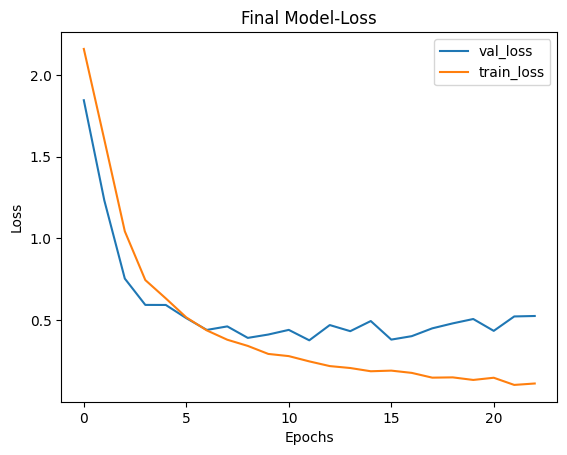

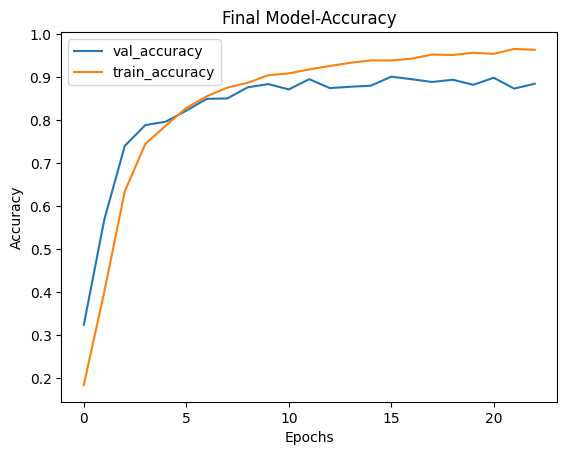

In [13]:
training_results(model6_vgg16_history)